# Linear Regression via Gradient Descent Tutorial

In [1]:
%matplotlib inline

import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt


This notebook shows how to implement linear regression via gradient descent on a set of points in 2D.  

We implement a class called LinearRegressionModelVectorized to compute the best-fit line.  
That is, this model computes the slope and intercept of the line that best fits the set of input x, y points.  
Best fit is defined as the line such that for the set of input points, the mean of the squared distance of each point to the line in the y direction is minimized. That is, if 

$m = $ number of points  
$w = $ slope (w stands for a learned weight in machine learning models)<br>
$b = $ intercept   

And the output of the model for any $x$ is:  

$$\hat{y} = wx + b$$

We want chose $w$ and $b$ to minimize cost $J$:

$$J = \frac{1}{m} \sum_{i=1}^{m} (y - \hat{y})^2$$

The y-squared loss for any particular point is:

$$\mathscr{L} = \frac{1}{2} (y - \hat{y})^2 = \frac{1}{2}(y^2 - 2y\hat{y} + \hat{y}^2)$$

The derivative of $\mathscr{L}$ with respect to $\hat{y}$ is:

$$ \frac{d \mathscr{L}}{d \hat{y}} = \frac{1}{2}(-2y + 2\hat{y}) = \hat{y} - y $$

Then we compute the partials of $\hat{y}$ with respect to $w$ and $b$:

$$\frac{\partial \hat{y}}{\partial w} = x$$

$$\frac{\partial \hat{y}}{\partial b} = 1$$

We then use the chain rule to get what we need: the partials of the loss $\mathscr{L}$ with repect to $w$ and $b$:

$$ \frac{\partial \mathscr{L}}{\partial w} = \frac{d \mathscr{L}}{d \hat{y}} \frac{\partial \hat{y}}{\partial w} = x(\hat{y} - y)$$

$$ \frac{\partial \mathscr{L}}{\partial b} = \frac{d \mathscr{L}}{d \hat{y}} \frac{\partial \hat{y}}{\partial b} = (\hat{y} - y)$$

To compute the gradients with respect to the overall cost $J$ we simply average across the losses for each point in the set:

$$\frac{\partial J}{\partial w} = \frac{1}{m} \sum_{i=1}^{m} x^{(i)}(\hat{y}^{(i)} - y^{(i)})$$

$$\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})$$

These gradients point in the direction of increasing cost $J$. So to decrease the cost, we move $w$ and $b$ a small amount in the opposite directions of the gradients. Let:

$\alpha = $ learning rate, typically a small number like $0.001$

We modify $w$ and $b$ with these equations:

$$w = w - \alpha \frac{\partial J}{\partial w}$$

$$b = b - \alpha \frac{\partial J}{\partial b}$$

We see this implemented in the __fit()__ function for the `LinearRegressionModelVectorized` class below.


### What we want:

After we have trained a model, we want it to have learned a line with slope and intercept very close to the ones you get from the usual formula for the linear regression best-fit line. Here is an example of a set of points and the linear regression best-fit line. We want this:

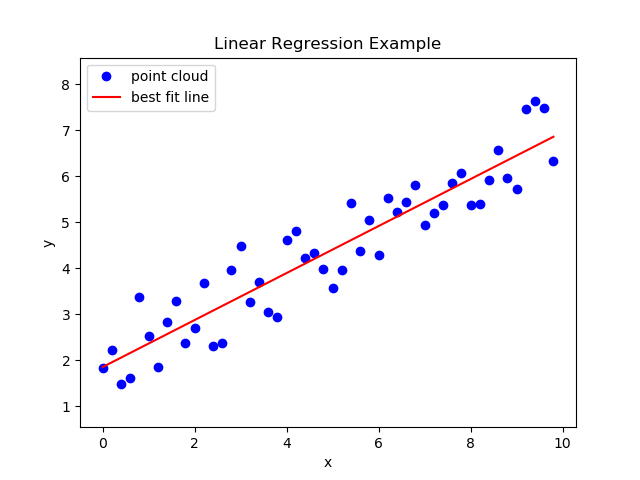

In [2]:
def read_points_file(fname, delim='\t'):
    """Read x y points from a text file, returning numpy arrays containing the x coordinates and the y coordinates.

    Each line in the text file holds one point. m points total.
    :param fname: Name of file holding x, y coordinates
    :type fname: string
    :param delim: Deliminter between fields in the text file
    :type delim: string (one character)
    :return xs: Array holding x coordinate of points
    :type xs: numpy array of floats of shape (1, m)
    :return ys: Array holding y coordinate of points
    :type ys: numpy array of floats of shape (1, m)
    """
    dat1 = np.loadtxt(fname, delimiter=delim)
    m = dat1.shape[0]
    xs = dat1[:, 0].reshape(1,m)
    ys = dat1[:, 1].reshape(1,m)
    return xs, ys

In [3]:
class LinearRegressionModelVectorized:
    """
    Class used to implement linear regression model, vectorized using numpy.

    Attributes
    ----------
    coef_ : linear model coefficients
    intercept_ : linear model intercept

    Methods
    -------
    fit(x, y, nepochs) : compute coefficients of best fit line
    """

    def __init__(self, slope=0.0, intercept=0.0):
        """
        Parameters
        ----------
        slope : float, optional
            Initial value of slope
        intercept : float, optional
            Initial value of intercept
        """

        self.coef_ = np.zeros(1)
        self.coef_[0] = slope
        self.intercept_ = intercept
        self.cost_ = 0.0
        self.r2_score_ = -999999999.0
        
    def fit(self, xs, ys, nepochs=10, learnrate=0.01):
        """Computes slope and intercept of best fit line for points.

        Parameters
        ----------
        xs : numpy array of shape (m,) floats where m is the number of points
            The x coordinates of the points
        ys : numpy array of shape (m,) floats
            The y coordinates of the points
        nepochs : int
            Number of training epochs
        learnrate : float
            Learning rate

        Action
        Computes the slope and interecept of the best-fit line for a set of points
        and put those into coef_[0][0] and intercept_ , respectively.
        """

        # A couple checks on the parameters:
        # The xs and ys must be the same length
        assert(xs.shape == ys.shape)
        # We need to run for at least 1 epoch
        assert(nepochs > 0)

        w = self.coef_[0]
        b = self.intercept_

        # We'll need the number of points a lot:
        m = xs.size

        # The mean of the y values will be used for evaluating the model.
        y_mean = ys.mean()

        sys.stderr.write('m: {}\n'.format(m))
        sys.stderr.write('y_mean: {}\n'.format(y_mean))
        sys.stderr.write('Initial w {}    b {}\n'.format(w, b))
        
        # How often to print training stats.
        training_stats_interval = 100
        if nepochs < 210:
            training_stats_interval = 10
        elif nepochs > 40000:
            training_stats_interval = 1000

        t0 = time.perf_counter()

        for epoch in range(nepochs):
            # Compute cost J and gradients at each epoch

            # Compute activation (or yhat) for x_i using current w and b.
            A = w * xs + b
            dz = (A - ys)
            # Use mean squared error loss
            J = (dz*dz).sum() / m
            dw = np.asscalar(np.dot(xs, dz.T)) / m
            db = np.sum(dz) / m

            w -= learnrate * dw
            b -= learnrate * db

            if (epoch % training_stats_interval) == 0:
                # sys.stderr.write('\ndw: {}\n'.format(dw))
                # sys.stderr.write('db: {}\n'.format(db))
                sys.stderr.write('epoch: {:6d}\tcost: {:8.4f}\tw: {:8.4f}\tb: {:8.4f}\n'.format(epoch, J, w, b))

        t1 = time.perf_counter()
        sys.stderr.write('Train time: {0:10.4f} sec\n'.format(t1 - t0))
        
        # Evaluations:
        # Compute R^2 metric
        null_model_v = (1.0/m) * ((ys - y_mean)**2).sum()

        self.r2_score_ = 1.0 - (J / null_model_v)
        self.coef_[0] = w
        self.intercept_ = b
        self.cost_ = J
        return w, b

## Run the linear regression model

To run the linear regression model we defined above, we:
* Set the values of variables we would have set via the command line.
* Read the x, y points in from the points_filename
* Build and run the linear regression model
* Plot the points and the linear regression model line.

In [14]:
# Parameters for running the linear regression model
examples_dir = '/Users/jay/github/ml-examples'
data_dir = os.path.join(examples_dir, 'data')
points_basename = 'linpoints50.txt'
points_filename = os.path.join(data_dir, points_basename)

plot_filename = '_regression.png'
nepochs = 3001
learnrate = 0.01


In [5]:
# Read points
xs, ys = read_points_file(points_filename)

print('xs shape: {}'.format(xs.shape))
print('ys shape: {}'.format(ys.shape))

xs shape: (1, 50)
ys shape: (1, 50)


In [8]:
xs

array([[0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
        2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ,
        5.2, 5.4, 5.6, 5.8, 6. , 6.2, 6.4, 6.6, 6.8, 7. , 7.2, 7.4, 7.6,
        7.8, 8. , 8.2, 8.4, 8.6, 8.8, 9. , 9.2, 9.4, 9.6, 9.8]])

In [9]:
ys

array([[1.83056902, 2.23812325, 1.49756468, 1.61105334, 3.36954988,
        2.52991594, 1.85358639, 2.82712291, 3.29429889, 2.38561304,
        2.6999882 , 3.6825839 , 2.31836158, 2.36928074, 3.97458022,
        4.49206819, 3.28087962, 3.6981885 , 3.04548421, 2.93917345,
        4.6205305 , 4.81683152, 4.23010592, 4.33062231, 3.97880089,
        3.56622844, 3.966293  , 5.42226409, 4.37004455, 5.05126997,
        4.29740133, 5.53255125, 5.22384307, 5.44524551, 5.81744751,
        4.94776703, 5.20372972, 5.37910156, 5.8652039 , 6.08466062,
        5.3799572 , 5.39944029, 5.92325333, 6.57691974, 5.96654933,
        5.71632606, 7.46726586, 7.63447734, 7.47657535, 6.34280503]])

### Compute the best fit linear regression model

For the example set of points shown below, the best-fit line computed using the usual formula has parameters:<br>
$slope = 0.511$<br>
$intercept = 1.856$

In [15]:
linregmodel = LinearRegressionModelVectorized(slope=0.1, intercept=0.1)
slope, b = linregmodel.fit(xs, ys, nepochs=nepochs, learnrate=learnrate)
print('Best fit model: cost {}\tslope: {}\tb: {}'.format(linregmodel.cost_, slope, b))
print('R^2 score: {}'.format(linregmodel.r2_score_))

Best fit model: cost 0.3269400493598352	slope: 0.5109415572357526	b: 1.855600284990892
R^2 score: 0.8692482951090565


m: 50
y_mean: 4.3594299638116
Initial w 0.1    b 0.1
epoch:      0	cost:  15.9414	w:   0.3189	b:   0.1377
epoch:    100	cost:   0.7532	w:   0.7067	b:   0.5733
epoch:    200	cost:   0.5844	w:   0.6631	b:   0.8592
epoch:    300	cost:   0.4825	w:   0.6292	b:   1.0814
epoch:    400	cost:   0.4209	w:   0.6028	b:   1.2541
epoch:    500	cost:   0.3837	w:   0.5823	b:   1.3883
epoch:    600	cost:   0.3612	w:   0.5664	b:   1.4926
epoch:    700	cost:   0.3476	w:   0.5540	b:   1.5737
epoch:    800	cost:   0.3394	w:   0.5444	b:   1.6367
epoch:    900	cost:   0.3345	w:   0.5369	b:   1.6857
epoch:   1000	cost:   0.3315	w:   0.5311	b:   1.7237
epoch:   1100	cost:   0.3297	w:   0.5266	b:   1.7533
epoch:   1200	cost:   0.3286	w:   0.5231	b:   1.7763
epoch:   1300	cost:   0.3279	w:   0.5203	b:   1.7941
epoch:   1400	cost:   0.3275	w:   0.5182	b:   1.8080
epoch:   1500	cost:   0.3273	w:   0.5166	b:   1.8188
epoch:   1600	cost:   0.3272	w:   0.5153	b:   1.8272
epoch:   1700	cost:   0.3271	w:   0.5143	b:   

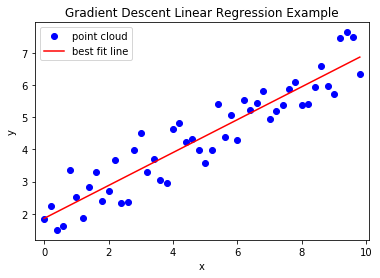

In [16]:
# Plot the points and the best-fit line

# Build two points to plot the best-fit line
xmin = xs.min()
xmax = xs.max()

x_fit = np.array([xmin, xmax])
y_fit = slope * x_fit + b

# Plot the points and line:
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gradient Descent Linear Regression Example')
plt.axis('equal')
plt.plot(xs[0], ys[0], 'bo', label='point cloud')
plt.plot(x_fit, y_fit, 'r-', label='best fit line')
plt.legend()
plt.show()
